In [10]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import sys
import os
import shap
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation

In [26]:
is_p = True
proc = GatherFeatureDatasets(is_p=is_p)

phase = "P"
if not is_p:
    phase = "S"

In [27]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
train = pd.read_csv(os.path.join(datadir, 'p.train.csv'))
outdir = "/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP"

In [28]:
feature_dict, meta_dict, feature_names = proc.process_station_datasets("YUF",
                                train, 
                                scaler=False,
                                linear_model=False,
                                source_dist_type='dist')

YUF
X shape: (1676, 45), y shape: (1676,)


In [29]:
station_feature_dict, station_meta_dict, feature_names = proc.process_all_stations_datasets(train, 
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')

YHB
X shape: (3580, 45), y shape: (3580,)
YDC
X shape: (2928, 45), y shape: (2928,)
YWB
X shape: (3780, 45), y shape: (3780,)
MCID
X shape: (3389, 45), y shape: (3389,)
YHL
X shape: (3213, 45), y shape: (3213,)
YMR
X shape: (4154, 45), y shape: (4154,)
YHH
X shape: (4813, 45), y shape: (4813,)
B207
X shape: (1718, 45), y shape: (1718,)
YPP
X shape: (1558, 45), y shape: (1558,)
YPM
X shape: (4078, 45), y shape: (4078,)
YLT
X shape: (1345, 45), y shape: (1345,)
H17A
X shape: (524, 45), y shape: (524,)
B208
X shape: (507, 45), y shape: (507,)
LKWY
X shape: (1062, 45), y shape: (1062,)
FLWY
X shape: (791, 45), y shape: (791,)
YGC
X shape: (2233, 45), y shape: (2233,)
YMC
X shape: (4322, 45), y shape: (4322,)
YML
X shape: (3077, 45), y shape: (3077,)
YUF
X shape: (1676, 45), y shape: (1676,)
B206
X shape: (664, 45), y shape: (664,)
B944
X shape: (348, 45), y shape: (348,)
YLA
X shape: (719, 45), y shape: (719,)
YTP
X shape: (926, 45), y shape: (926,)
YNR
X shape: (4649, 45), y shape: (4649,

In [30]:
feature_plot_names = proc.get_feature_plot_names(source_dist_type='dist')

In [6]:
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [7]:
feature_plot_names

array(['ratio 1', 'ratio 2', 'ratio 3', 'ratio 4', 'ratio 5', 'ratio 6',
       'ratio 7', 'ratio 8', 'ratio 9', 'ratio 10', 'ratio 11',
       'ratio 12', 'ratio 13', 'ratio 14', 'ratio 15', 'ratio 16',
       'ratio 17', 'ratio 18', 'amp. 1', 'amp. 2', 'amp. 3', 'amp. 4',
       'amp. 5', 'amp. 6', 'amp. 7', 'amp. 8', 'amp. 9', 'amp. 10',
       'amp. 11', 'amp. 12', 'amp. 13', 'amp. 14', 'amp. 15', 'amp. 16',
       'amp. 17', 'amp. 18', 'sig. dom. freq.', 'sig. dom. amp.',
       'noise max. amp.', 'sig. max. amp.', 'sig. var.', 'noise var.',
       'depth', 'distance', 'back az.'], dtype='<U15')

In [8]:
cv_random_state=2652124
C = 1
gamma = 0.1
cv_folds = 10
# The main model to fit
predictor_model = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=0.1)
# Boolean - True if data for model needs to be scaled 
model_scaler = True

In [9]:
cv = KFold(n_splits=cv_folds,
            shuffle=True,
            random_state=cv_random_state)


In [10]:
stat = "YUF"
full_train_X = station_feature_dict[stat]["X_train"]
full_train_y = station_meta_dict[stat]["y_train"]
fold = 0
all_shap_values = []
all_test_inds = []
for train_i_inds, test_i_inds in cv.split(full_train_X):
    print("fold:", fold)
    train_i_X = full_train_X[train_i_inds, :]
    train_i_y = full_train_y[train_i_inds]
    test_i_X = full_train_X[test_i_inds, :]
    test_i_y = full_train_y[test_i_inds]
    print(train_i_X.shape, test_i_X.shape)
    print(train_i_y.shape, test_i_y.shape)
    pipeline = CrossValidation.make_simple_pipeline(predictor_model, model_scaler)
    fold_model = pipeline.fit(train_i_X, train_i_y)
    
    # This is the primary interface that autoselects the algorithm to use. 
    # It chooses permutation for this model (explainer.__class__.__name__)
    # explainer = shap.Explainer(fold_model['m'].predict, 
    #                             fold_model['scaler'].transform(train_i_X))

    # Just explicitly use the permutation algorithm  
    explainer = shap.explainers.Permutation(fold_model['m'].predict, 
                                            fold_model['scaler'].transform(train_i_X),
                                            feature_names=feature_plot_names,
                                            seed=cv_random_state+1)
    
    shap_values = explainer(fold_model['scaler'].transform(test_i_X))
    
    with open(os.path.join(outdir, f'{stat}.{phase}.shap.permutation.fold{fold}.explainer'), 'wb') as file:
        explainer.save(file)

    np.savez(os.path.join(outdir, f"{stat}.{phase}.shap.permutation.fold{fold}.values"),
        values=shap_values.values, base_values=shap_values.base_values, data=shap_values.data)
    
    all_shap_values.append(shap_values.values)
    all_test_inds.append(all_test_inds)

    fold += 1

fold: 0
(1508, 45) (168, 45)
(1508,) (168,)


PermutationExplainer explainer: 169it [23:47,  8.50s/it]                         


fold: 1
(1508, 45) (168, 45)
(1508,) (168,)


PermutationExplainer explainer: 169it [28:36, 10.28s/it]                         


fold: 2
(1508, 45) (168, 45)
(1508,) (168,)


PermutationExplainer explainer: 169it [22:26,  8.11s/it]                         


fold: 3
(1508, 45) (168, 45)
(1508,) (168,)


PermutationExplainer explainer: 169it [26:04,  9.37s/it]                         


fold: 4
(1508, 45) (168, 45)
(1508,) (168,)


PermutationExplainer explainer: 169it [23:35,  8.53s/it]                         


fold: 5
(1508, 45) (168, 45)
(1508,) (168,)


PermutationExplainer explainer: 169it [27:26,  9.86s/it]                         


fold: 6
(1509, 45) (167, 45)
(1509,) (167,)


PermutationExplainer explainer: 168it [23:53,  8.64s/it]                         


fold: 7
(1509, 45) (167, 45)
(1509,) (167,)


PermutationExplainer explainer: 168it [24:19,  8.84s/it]                         


fold: 8
(1509, 45) (167, 45)
(1509,) (167,)


PermutationExplainer explainer: 168it [19:26,  7.07s/it]                         


fold: 9
(1509, 45) (167, 45)
(1509,) (167,)


PermutationExplainer explainer: 168it [19:15,  7.00s/it]                         


In [11]:
# Concatentate shap values

# Concatenate test inds

# shap.summary_plot(all_shap_values, full_train_X.reindex(all_test_inds))


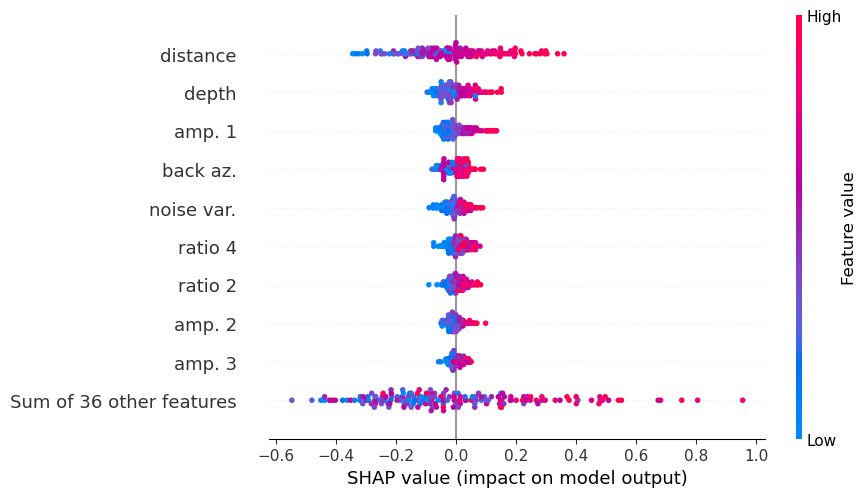

In [12]:
shap.plots.beeswarm(shap_values)

In [13]:
feature_names[np.argsort(-1*np.abs(shap_values.values).mean(0))]

array(['source_receiver_distance_logkm', 'source_depth_km', 'amp_1',
       'source_receiver_back_azimuth_deg', 'noise_variance',
       'amp_ratio_4', 'amp_ratio_2', 'amp_2', 'amp_3', 'amp_ratio_1',
       'amp_ratio_6', 'amp_ratio_3', 'amp_18', 'amp_4',
       'signal_dominant_frequency', 'amp_7', 'amp_6', 'amp_ratio_5',
       'amp_8', 'amp_ratio_7', 'amp_ratio_18', 'noise_max_amplitude',
       'amp_ratio_8', 'signal_max_amplitude', 'amp_5', 'amp_17',
       'signal_dominant_amplitude', 'amp_ratio_12', 'signal_variance',
       'amp_ratio_17', 'amp_ratio_11', 'amp_9', 'amp_ratio_10',
       'amp_ratio_9', 'amp_15', 'amp_16', 'amp_ratio_13', 'amp_12',
       'amp_11', 'amp_14', 'amp_13', 'amp_ratio_16', 'amp_10',
       'amp_ratio_15', 'amp_ratio_14'], dtype='<U32')

# Read in saved results and plot

In [21]:
import glob

values = []
base_values = []
data = []
for file in glob.glob(os.path.join(outdir, "P_data/YUF/*values.npz")):
    print(file)
    fold_results = np.load(file)
    values.append(fold_results["values"])
    base_values.append(fold_results["base_values"])
    data.append(fold_results["data"])


/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold0.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold1.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold2.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold3.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold4.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold5.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold6.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/SHAP/P_data/YUF/YUF.P.shap.permutation.fold7.values.npz
/uufs/chpc.utah.edu/common/home/koper-group3/aly

In [22]:
values = np.concatenate(values)
print(values.shape)
base_values = np.concatenate(base_values)
print(base_values.shape)
data = np.concatenate(data)
print(data.shape)


(1676, 45)
(1676,)
(1676, 45)


In [31]:
explaination = shap.Explanation(values=values, 
                                base_values=base_values,
                                data=data,
                                feature_names=feature_plot_names)

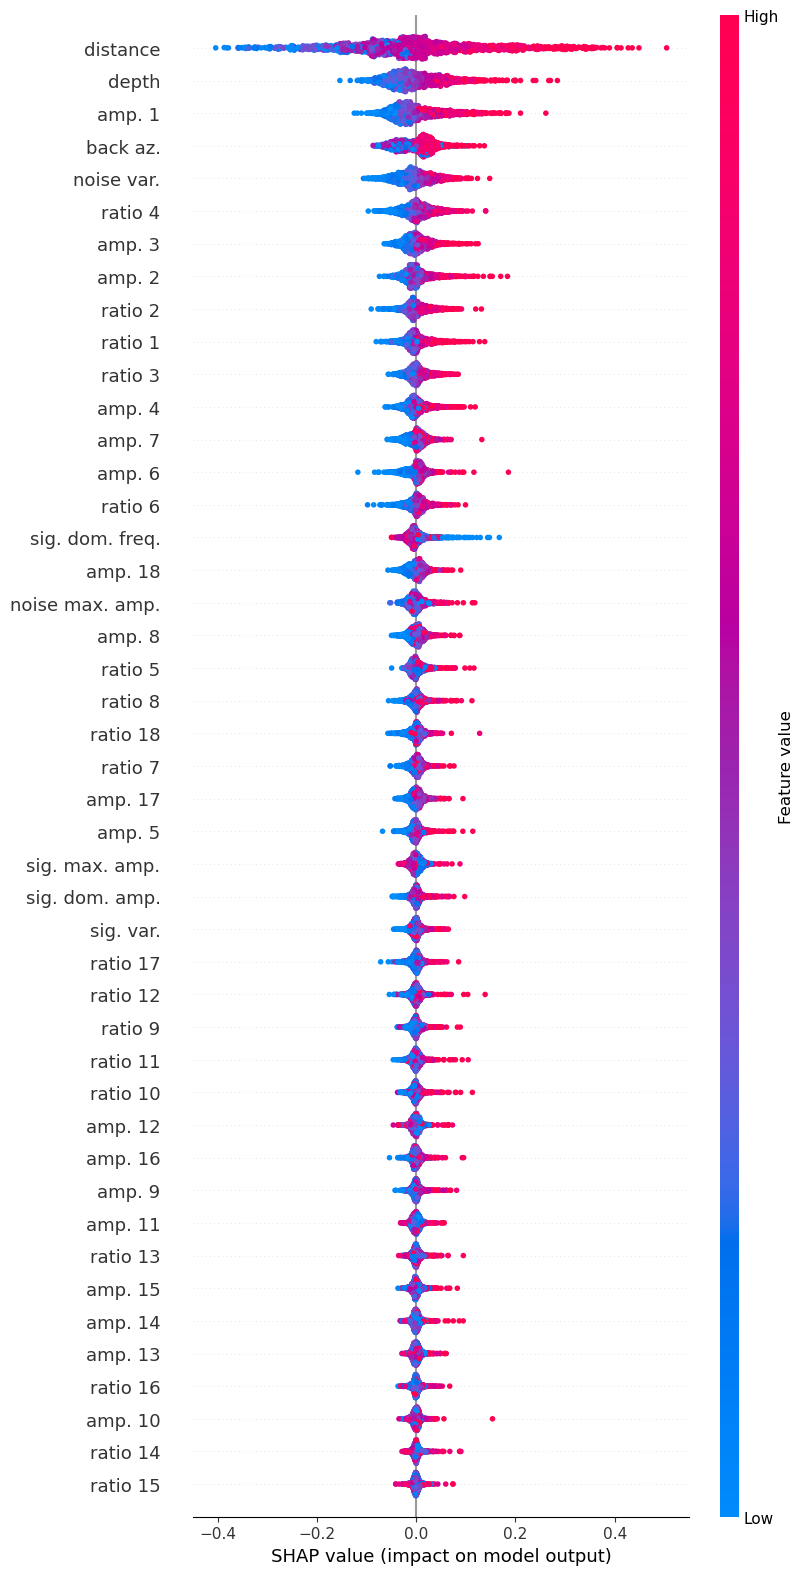

In [36]:
shap.plots.beeswarm(explaination, max_display=45)